In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize,
    pop_behavior
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from plotting_utils import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from pathlib import Path

set_rc()

# Load BART data

In [75]:
bart_folder = './data/BART_data'
bart_folder = Path(bart_folder)

found_sessions = []

sessions = list(bart_folder.iterdir())
for session in sessions:
    files = list(session.iterdir())
    for file in files:
        if 'task_data' in file.name:
            found_sessions.append(file)

dfs = [pd.read_excel(sess) for sess in found_sessions]

In [76]:
all_its = []
all_unpopped_its = []
all_pops = []
all_mean_its = []
all_total_scores = []
all_weighted_scores = []
all_pop_rates = []
ep_pop_rates = []
all_balloon_counts = []

for df in dfs:
    its = []
    pops = []
    counts = []
    weighted_scores = []
    balloon_colors = ['red', 'orange', 'yellow']
    
    for color in balloon_colors:
        s = df[df['balloonType'] == color]
        its.append(s['inflationTime(ms)'].to_numpy())
        pops.append((s['outcome'] == 'popped').to_numpy())
        counts.append(len(s))
        weighted_scores.append(s[s['outcome'] == 'banked']['inflationTime(ms)'].sum())
    unpopped = [its[i][~pops[i]] for i in range(3)]

    all_its.append(its)
    all_mean_its.append([np.mean(it) for it in its])
    all_pops.append(pops)
    all_unpopped_its.append(unpopped)
    
    all_pop_rates.append(np.mean([np.mean(p) for p in pops]))
    ep_pop_rates.append([np.mean(p) for p in pops])
    all_total_scores.append(df.iloc[-1]['total reward'])
    all_weighted_scores.append(np.sum(weighted_scores) / 1000)
    # all_balloon_counts.append(np.sum(counts))
    all_balloon_counts.append(counts)
    
all_mean_means = np.array(all_mean_its).mean(axis=1)

In [77]:
# Calculate exploration rates based on how much ITs tend to climb over time.
#  Computed as the greatest change in average over time from each iteration
#  Starts calculation from 10th balloon, since some individuals have much
#    smaller starting sizes which throws off the calculation
#  Exploration of > 0.3 is pretty strong use of exploration
all_exploration_scores = []
for unpopped in all_unpopped_its:
    expl = 0
    for it in unpopped:
        sm_it = np.array(pd.Series(it).ewm(alpha=0.1).mean())[10:]
        max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
        expl += max_diff
    gradual_exploration = expl / (3 * 2000)
    all_exploration_scores.append(gradual_exploration)

# Calculate bimodal IT
all_bimodal_its = []
for unpopped in all_unpopped_its:
    its = np.concatenate(unpopped)
    _, p = diptest(its)
    all_bimodal_its.append(p < 0.05)

mean_diffs = [np.diff(it)/1000 for it in all_mean_its]
simple_bimodal = []
for i in range(len(mean_diffs)):
    diff = mean_diffs[i]
    if diff[0] < diff[1]*0.5 or diff[1] < diff[0]*0.5:
        simple_bimodal.append(True)
    else:
        simple_bimodal.append(False)

all_explorations = np.array(all_exploration_scores) > 0.35
all_bimodal_its = np.array(all_bimodal_its)
all_simple_bimodal = np.array(simple_bimodal)

print(all_explorations.sum())
print(all_simple_bimodal.sum())

5
5


c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Exploration rate: 0.17
Explorer: False
Mean diffs: [0.9911736  1.03831852]
Bimodal: False


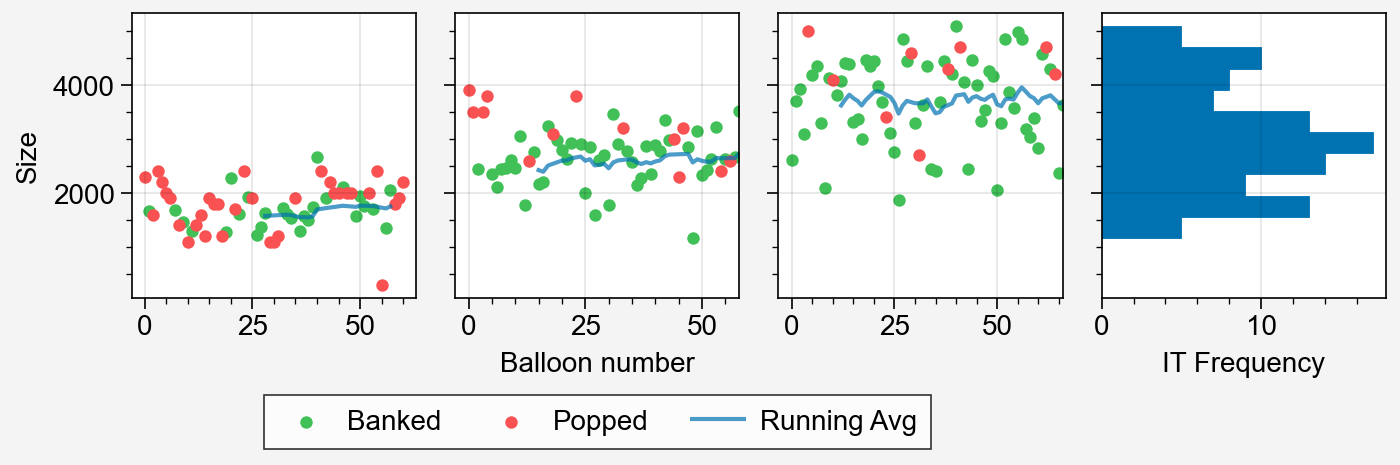

In [6]:
idx = 13

colors = ['Red', 'Orange', 'Yellow']
its, pops = all_its[idx], all_pops[idx]
fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
for i in range(3):
    lines = []
    it = its[i]
    pop = pops[i]
    lines.append(ax[i].scatter(np.argwhere(~pop), it[~pop], c='green6', s=15, label='Banked'))
    lines.append(ax[i].scatter(np.argwhere(pop), it[pop], c='red6', s=15, label='Popped'))
    lines.append(ax[i].plot(np.argwhere(~pop)[10:], np.array(pd.Series(it[~pop]).ewm(alpha=0.1).mean())[10:],
               alpha=0.7, label='Running Avg'))

ax[1].format(ylabel='Size', xlabel='Balloon number')
ax[1].legend(lines, loc='b')
ax[3].format(xlabel='IT Frequency')

its = np.concatenate([i[10:] for i in all_unpopped_its[idx]])
ax[3].hist(its, orientation='horizontal')

print(f'Exploration rate: {all_exploration_scores[idx]:.2f}')
print(f'Explorer: {all_explorations[idx]}')
# print(f'Bimodal: {all_bimodal_its[idx]}')
print(f'Mean diffs: {mean_diffs[idx]}')
print(f'Bimodal: {simple_bimodal[idx]}')

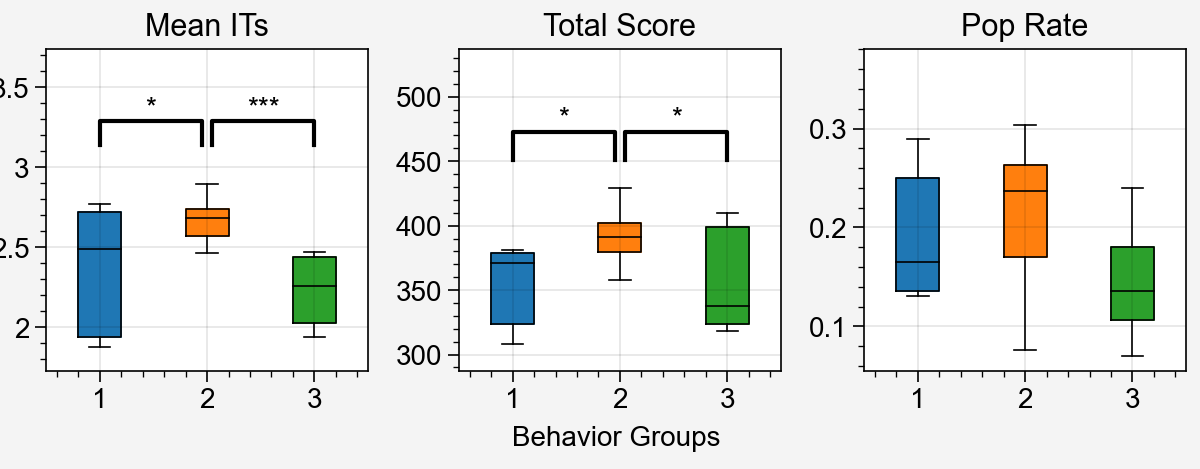

In [101]:
fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)
plot_vals = [
    np.array(all_mean_means) / 1000,
    all_weighted_scores,
    all_pop_rates
]
plot_titles = ['Mean ITs', 'Total Score', 'Pop Rate']
groups = [
    all_explorations,
    ~(all_explorations | all_simple_bimodal),
    all_simple_bimodal
]
for i, vals in enumerate(plot_vals):
    ys = []
    for j, group in enumerate(groups):
        y = np.array(vals)[group]
        ys.append(y)
        b = ax[i].boxplot(j, y, widths=0.4, fliers=False)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_titles[i])
    agent_type_significance_test(ys, ax[i], boxplot=True)

ax.format(xlabel='Behavior Groups', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])
    

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Exploration rate: 0.17
Explorer: False
Mean diffs: [0.9911736  1.03831852]
Bimodal: False


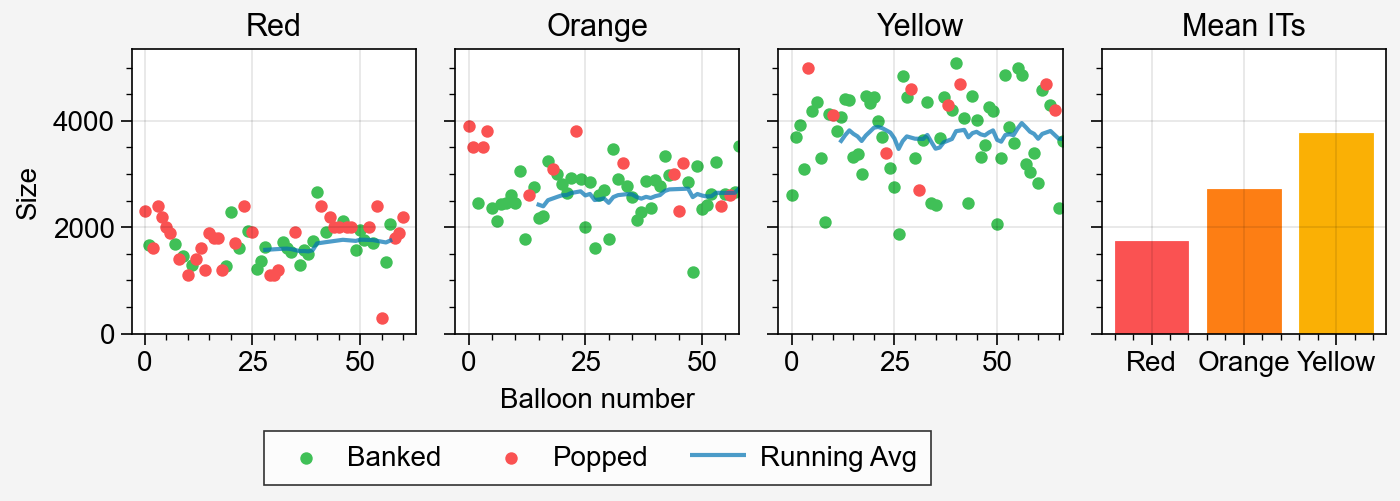

In [14]:
idx = 13

colors = ['Red', 'Orange', 'Yellow']
its, pops = all_its[idx], all_pops[idx]
fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
for i in range(3):
    lines = []
    it = its[i]
    pop = pops[i]
    lines.append(ax[i].scatter(np.argwhere(~pop), it[~pop], c='green6', s=15, label='Banked'))
    lines.append(ax[i].scatter(np.argwhere(pop), it[pop], c='red6', s=15, label='Popped'))
    lines.append(ax[i].plot(np.argwhere(~pop)[10:], np.array(pd.Series(it[~pop]).ewm(alpha=0.1).mean())[10:],
               alpha=0.7, label='Running Avg'))
    ax[i].format(title=colors[i])

ax[1].format(ylabel='Size', xlabel='Balloon number',)
ax[1].legend(lines, loc='b')

means = all_mean_its[idx]
ax[3].sharey = False
ax[3].bar(means, c=['red6', 'orange6', 'yellow6'])
ax[3].format(xlocator=range(3), xformatter=colors, title='Mean ITs')

its = np.concatenate([i[10:] for i in all_unpopped_its[idx]])

print(f'Exploration rate: {all_exploration_scores[idx]:.2f}')
print(f'Explorer: {all_explorations[idx]}')
# print(f'Bimodal: {all_bimodal_its[idx]}')
print(f'Mean diffs: {mean_diffs[idx]}')
print(f'Bimodal: {simple_bimodal[idx]}')

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Exploration rate: 0.16
Explorer: False
Mean diffs: [1.42625    0.63532983]
Bimodal: True


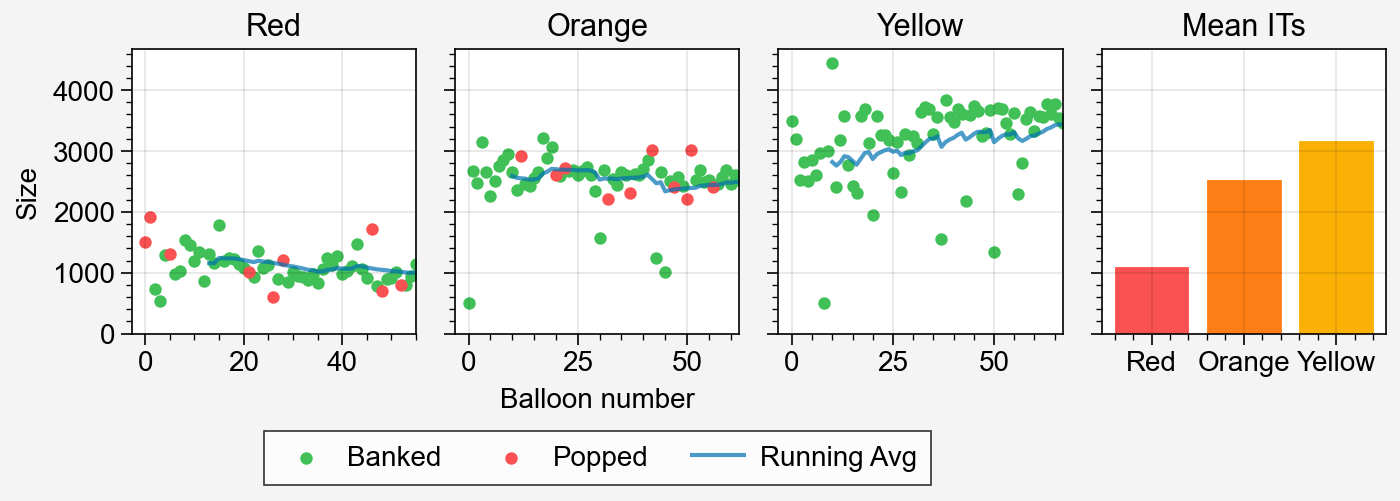

In [22]:
idx = 5

colors = ['Red', 'Orange', 'Yellow']
its, pops = all_its[idx], all_pops[idx]
fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
for i in range(3):
    lines = []
    it = its[i]
    pop = pops[i]
    lines.append(ax[i].scatter(np.argwhere(~pop), it[~pop], c='green6', s=15, label='Banked'))
    lines.append(ax[i].scatter(np.argwhere(pop), it[pop], c='red6', s=15, label='Popped'))
    lines.append(ax[i].plot(np.argwhere(~pop)[10:], np.array(pd.Series(it[~pop]).ewm(alpha=0.1).mean())[10:],
               alpha=0.7, label='Running Avg'))
    ax[i].format(title=colors[i])

ax[1].format(ylabel='Size', xlabel='Balloon number',)
ax[1].legend(lines, loc='b')

means = all_mean_its[idx]
ax[3].sharey = False
ax[3].bar(means, c=['red6', 'orange6', 'yellow6'])
ax[3].format(xlocator=range(3), xformatter=colors, title='Mean ITs')

its = np.concatenate([i[10:] for i in all_unpopped_its[idx]])

print(f'Exploration rate: {all_exploration_scores[idx]:.2f}')
print(f'Explorer: {all_explorations[idx]}')
# print(f'Bimodal: {all_bimodal_its[idx]}')
print(f'Mean diffs: {mean_diffs[idx]}')
print(f'Bimodal: {simple_bimodal[idx]}')

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Exploration rate: 0.47
Explorer: True
Mean diffs: [0.49956613 0.31858879]
Bimodal: False


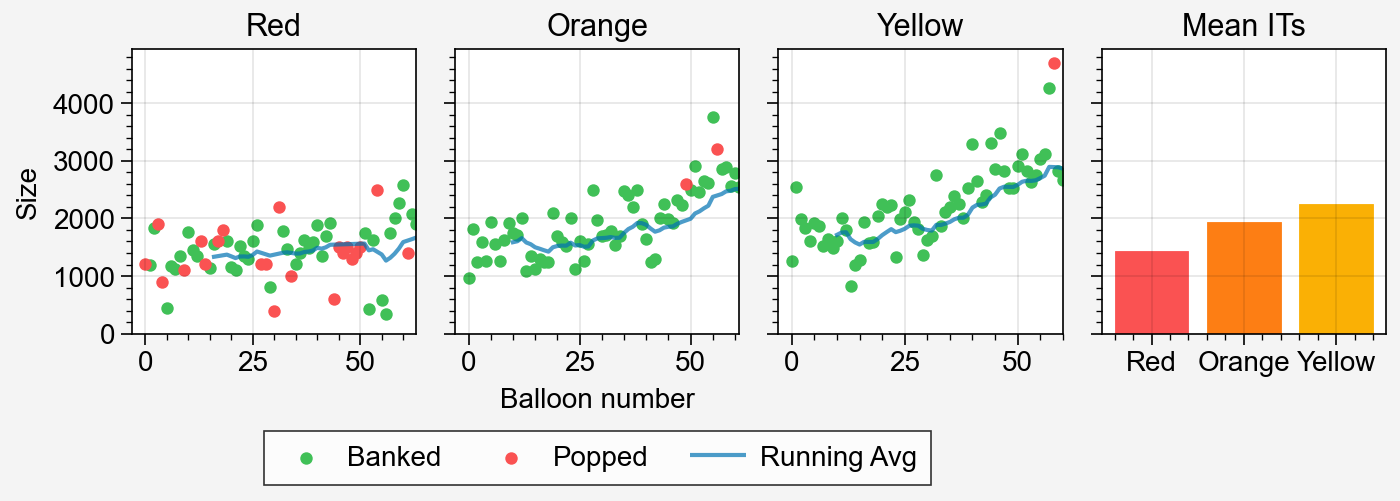

In [28]:
idx = 16

colors = ['Red', 'Orange', 'Yellow']
its, pops = all_its[idx], all_pops[idx]
fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
for i in range(3):
    lines = []
    it = its[i]
    pop = pops[i]
    lines.append(ax[i].scatter(np.argwhere(~pop), it[~pop], c='green6', s=15, label='Banked'))
    lines.append(ax[i].scatter(np.argwhere(pop), it[pop], c='red6', s=15, label='Popped'))
    lines.append(ax[i].plot(np.argwhere(~pop)[10:], np.array(pd.Series(it[~pop]).ewm(alpha=0.1).mean())[10:],
               alpha=0.7, label='Running Avg'))
    ax[i].format(title=colors[i])

ax[1].format(ylabel='Size', xlabel='Balloon number',)
ax[1].legend(lines, loc='b')

means = all_mean_its[idx]
ax[3].sharey = False
ax[3].bar(means, c=['red6', 'orange6', 'yellow6'])
ax[3].format(xlocator=range(3), xformatter=colors, title='Mean ITs')

its = np.concatenate([i[10:] for i in all_unpopped_its[idx]])

print(f'Exploration rate: {all_exploration_scores[idx]:.2f}')
print(f'Explorer: {all_explorations[idx]}')
# print(f'Bimodal: {all_bimodal_its[idx]}')
print(f'Mean diffs: {mean_diffs[idx]}')
print(f'Bimodal: {simple_bimodal[idx]}')

In [6]:
def ewma(data, alpha=0.1):
    ewma_values = np.zeros_like(data, dtype=np.float64)
    ewma_values[0] = data[0]
    for t in range(1, len(data)):
        ewma_values[t] = alpha * data[t] + (1 - alpha) * ewma_values[t - 1]
    return ewma_values

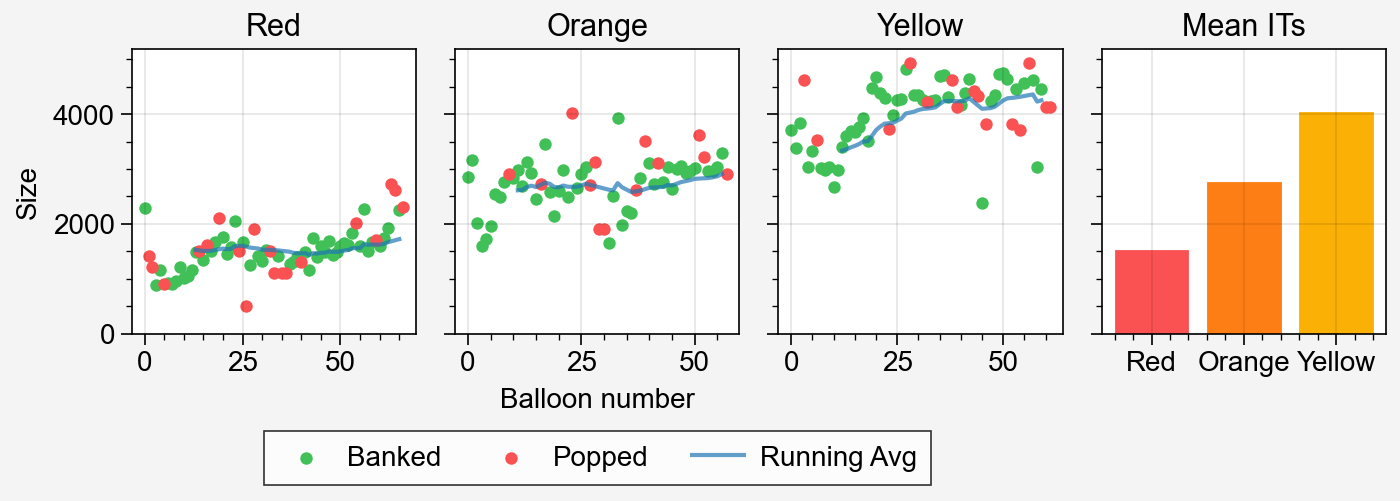

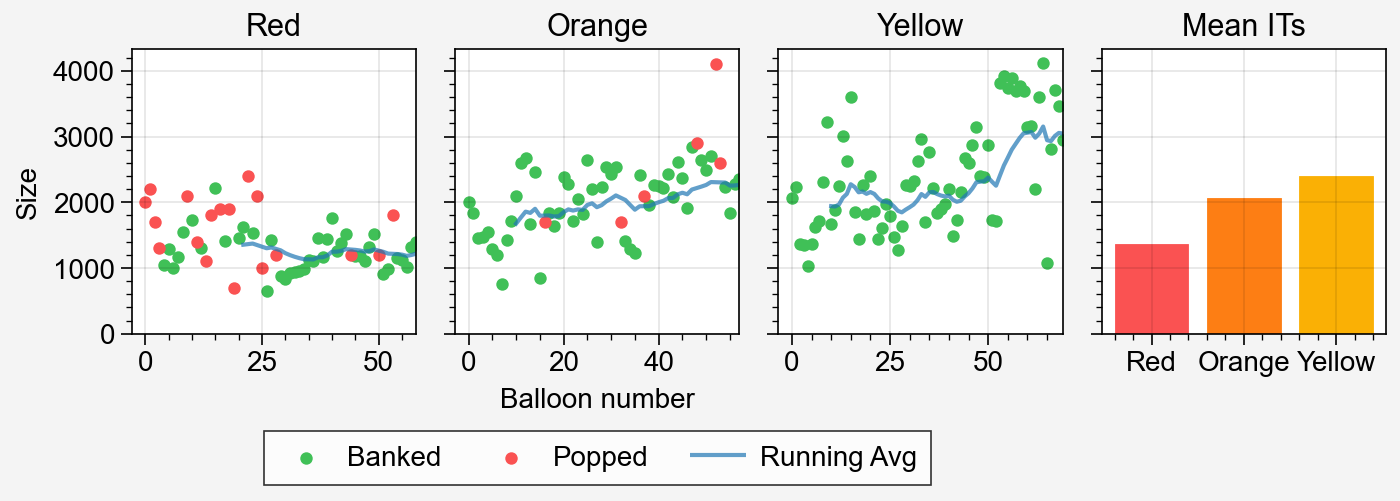

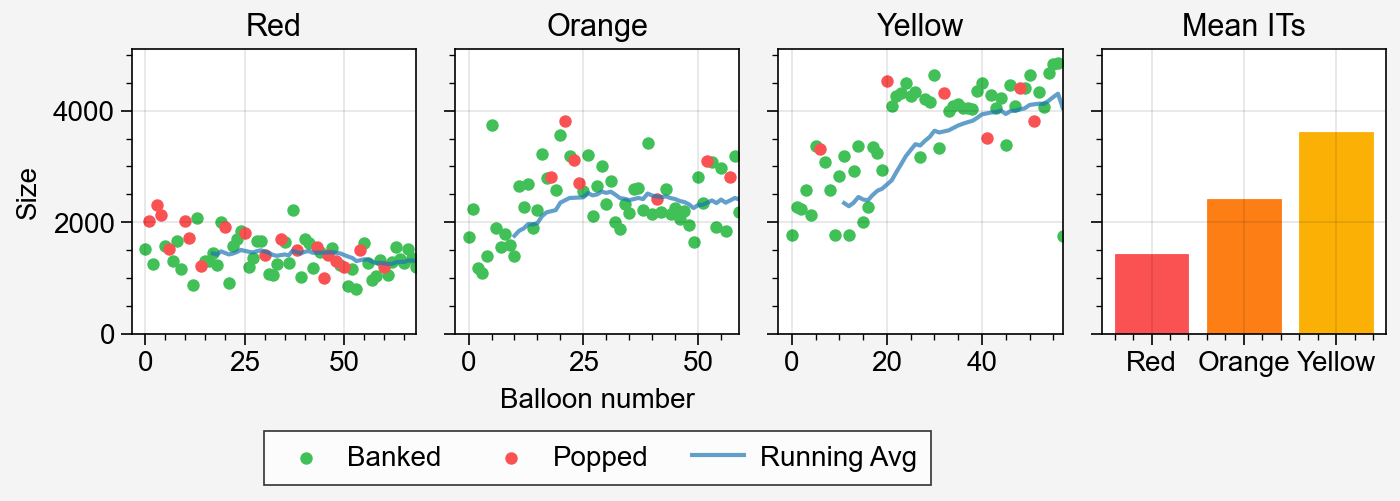

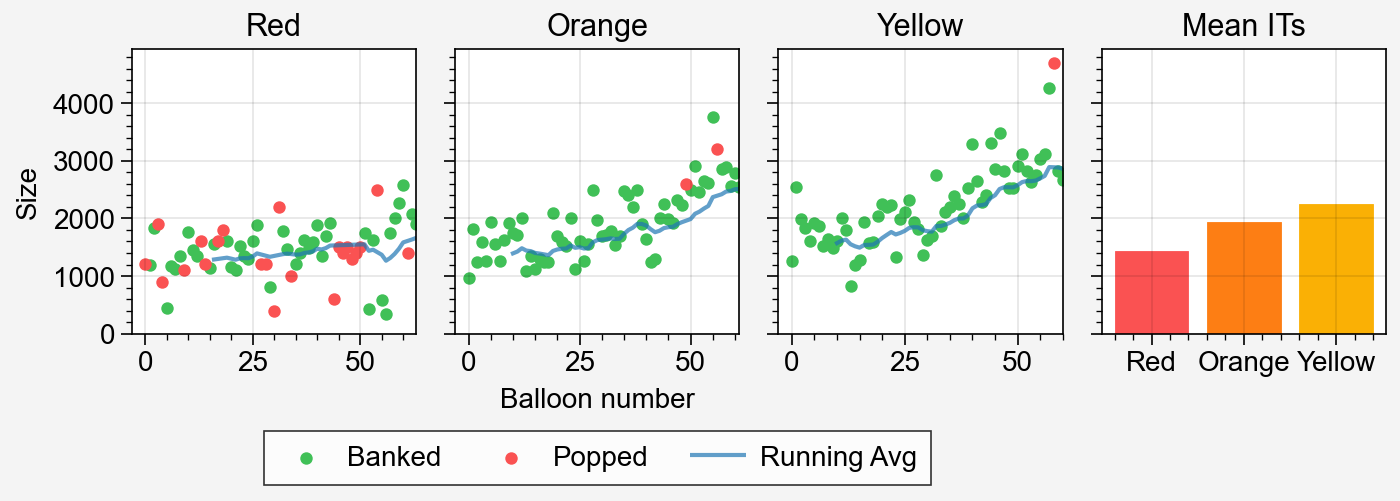

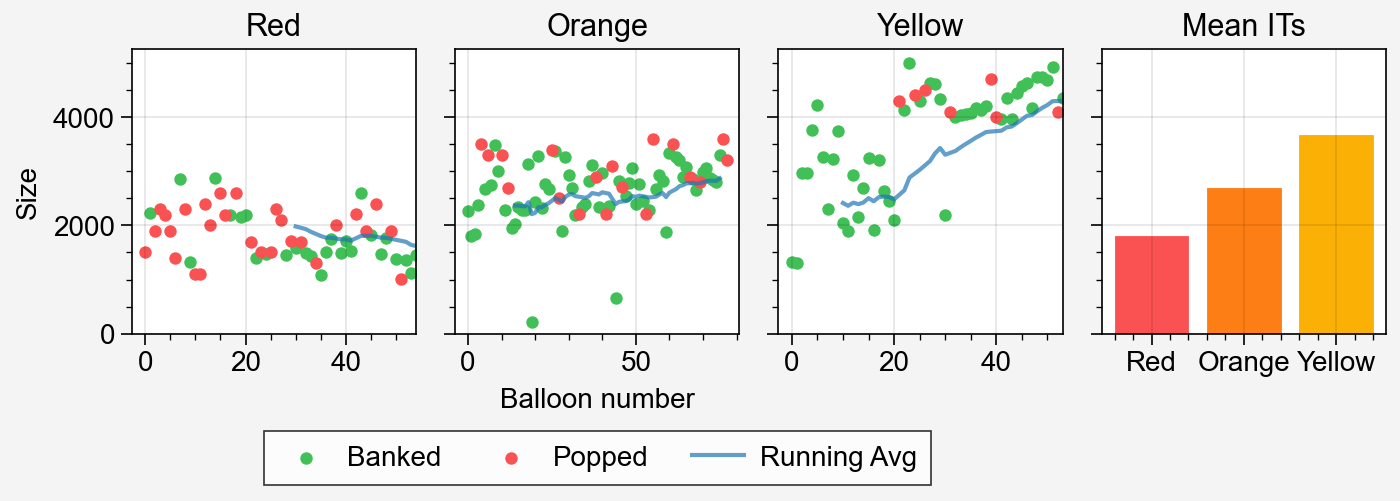

In [93]:
for idx in range(22):
    if all_explorations[idx]:
        
        colors = ['Red', 'Orange', 'Yellow']
        its, pops = all_its[idx], all_pops[idx]
        fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
        for i in range(3):
            lines = []
            it = its[i]
            pop = pops[i]
            pop_x = list(np.argwhere(pop).reshape(-1))
            nopop_x = list(np.argwhere(~pop).reshape(-1))
            pop_y = list(it[pop])
            nopop_y = list(it[~pop])
            avg = list(ewma(nopop_y))[10:]
            avg_x = np.array(nopop_x[10:], dtype='float')
            
            lines.append(ax[i].scatter(nopop_x, nopop_y, c='green6', s=15, label='Banked'))
            lines.append(ax[i].scatter(pop_x, pop_y, c='red6', s=15, label='Popped'))
            lines.append(ax[i].plot(avg_x, avg,
                    alpha=0.7, label='Running Avg', c=rgb_colors[0]))
            ax[i].format(title=colors[i])

        ax[1].format(ylabel='Size', xlabel='Balloon number',)
        ax[1].legend(lines, loc='b')

        means = all_mean_its[idx]
        ax[3].sharey = False
        ax[3].bar(means, c=['red6', 'orange6', 'yellow6'])
        ax[3].format(xlocator=range(3), xformatter=colors, title='Mean ITs')

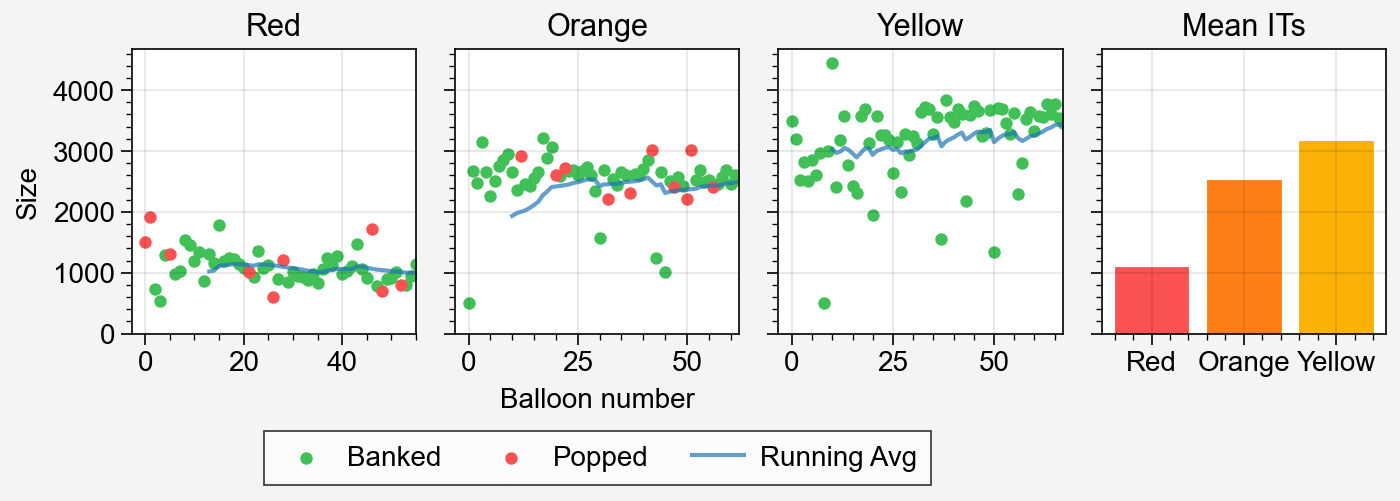

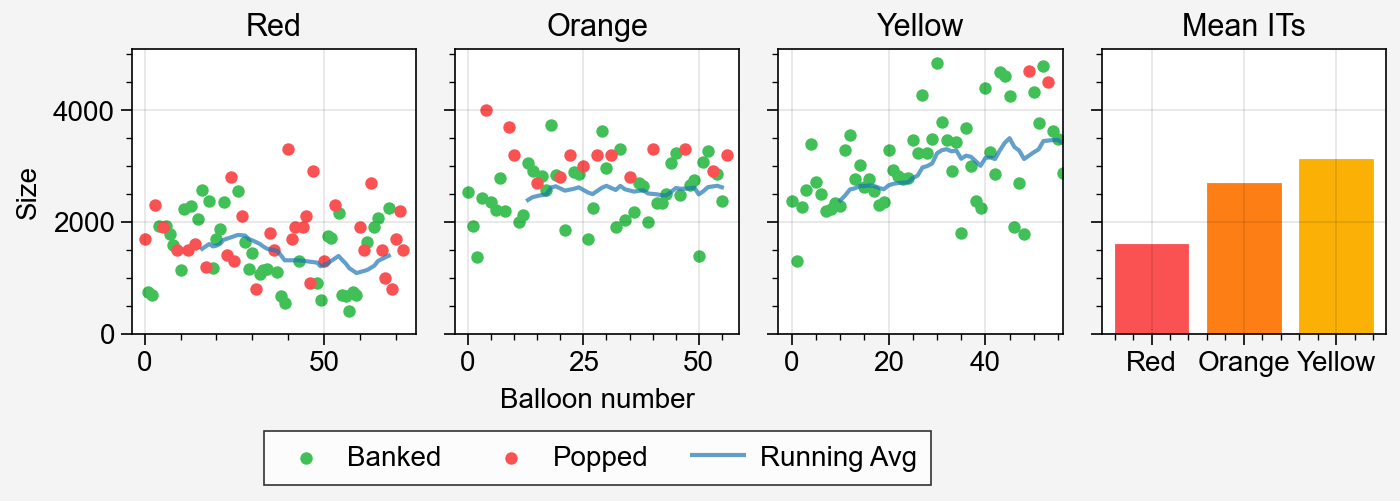

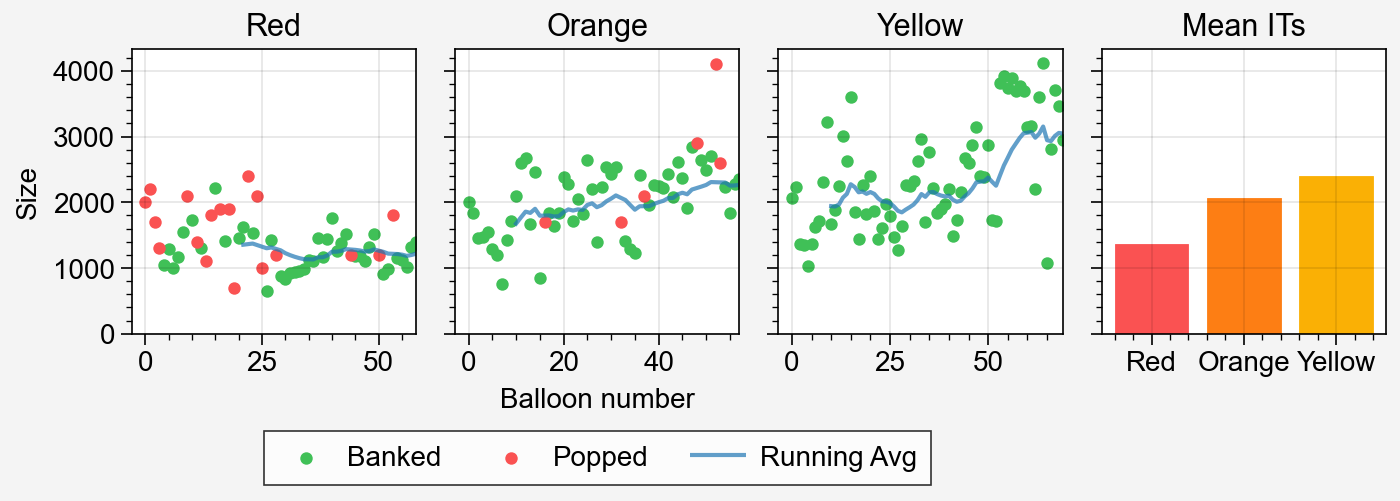

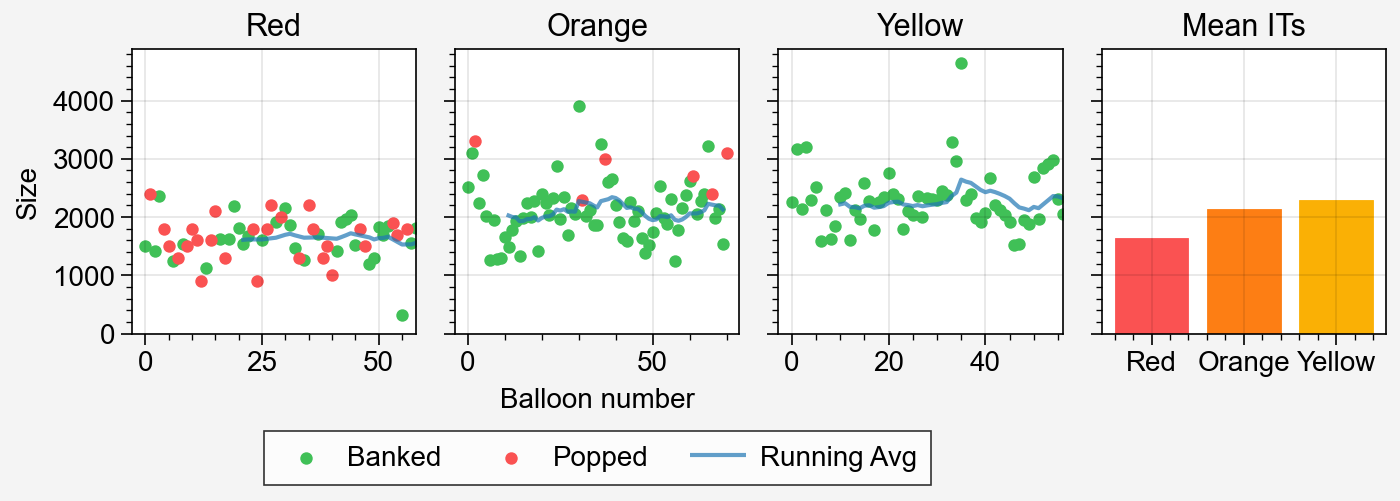

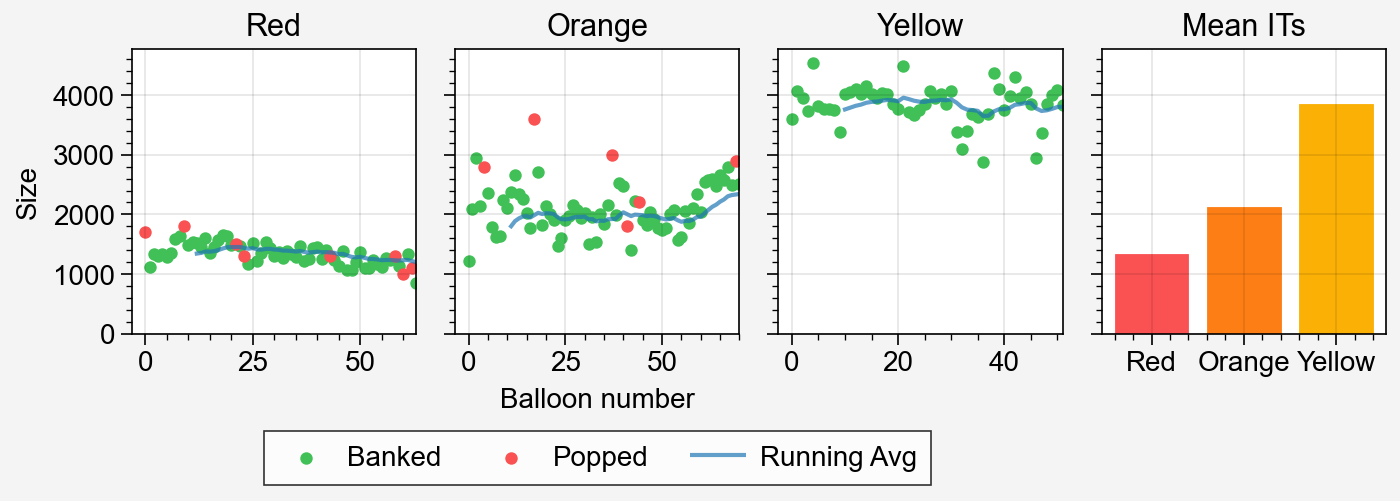

In [82]:
for idx in range(22):
    if all_simple_bimodal[idx]:
    # if all_bimodal_its[idx]:
        
        colors = ['Red', 'Orange', 'Yellow']
        its, pops = all_its[idx], all_pops[idx]
        fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
        for i in range(3):
            lines = []
            it = its[i]
            pop = pops[i]
            pop_x = list(np.argwhere(pop).reshape(-1))
            nopop_x = list(np.argwhere(~pop).reshape(-1))
            pop_y = list(it[pop])
            nopop_y = list(it[~pop])
            avg = list(ewma(nopop_y))[10:]
            avg_x = np.array(nopop_x[10:], dtype='float')
            
            lines.append(ax[i].scatter(nopop_x, nopop_y, c='green6', s=15, label='Banked'))
            lines.append(ax[i].scatter(pop_x, pop_y, c='red6', s=15, label='Popped'))
            lines.append(ax[i].plot(avg_x, avg,
                    alpha=0.7, label='Running Avg', c=rgb_colors[0]))
            ax[i].format(title=colors[i])

        ax[1].format(ylabel='Size', xlabel='Balloon number',)
        ax[1].legend(lines, loc='b')

        means = all_mean_its[idx]
        ax[3].sharey = False
        ax[3].bar(means, c=['red6', 'orange6', 'yellow6'])
        ax[3].format(xlocator=range(3), xformatter=colors, title='Mean ITs')

# Agent classifications based on these simplified measures

In [4]:
res = pickle.load(open('data/meta_representation_results', 'rb')) # arrays
ares = pickle.load(open('data/meta_rnn_gradients', 'rb')) # dicts
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb')) # dicts
node_ares = pickle.load(open('data/meta_single_node_characteristics', 'rb')) # arrays
summary = pickle.load(open('data/meta_summary', 'rb'))
shape = (2, 4, 5, 10)

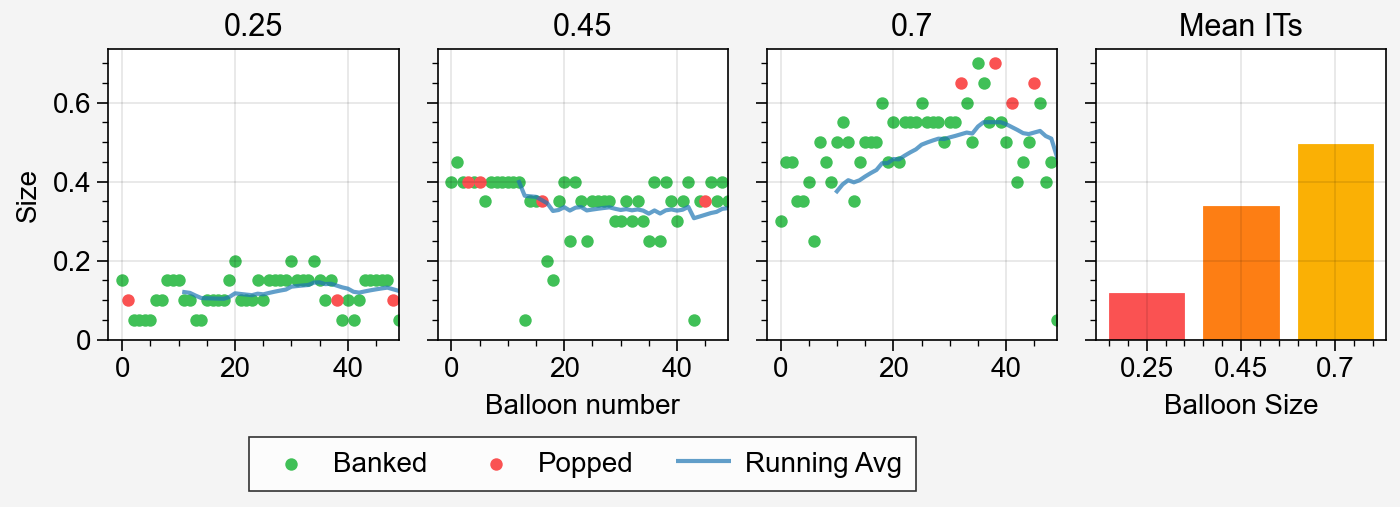

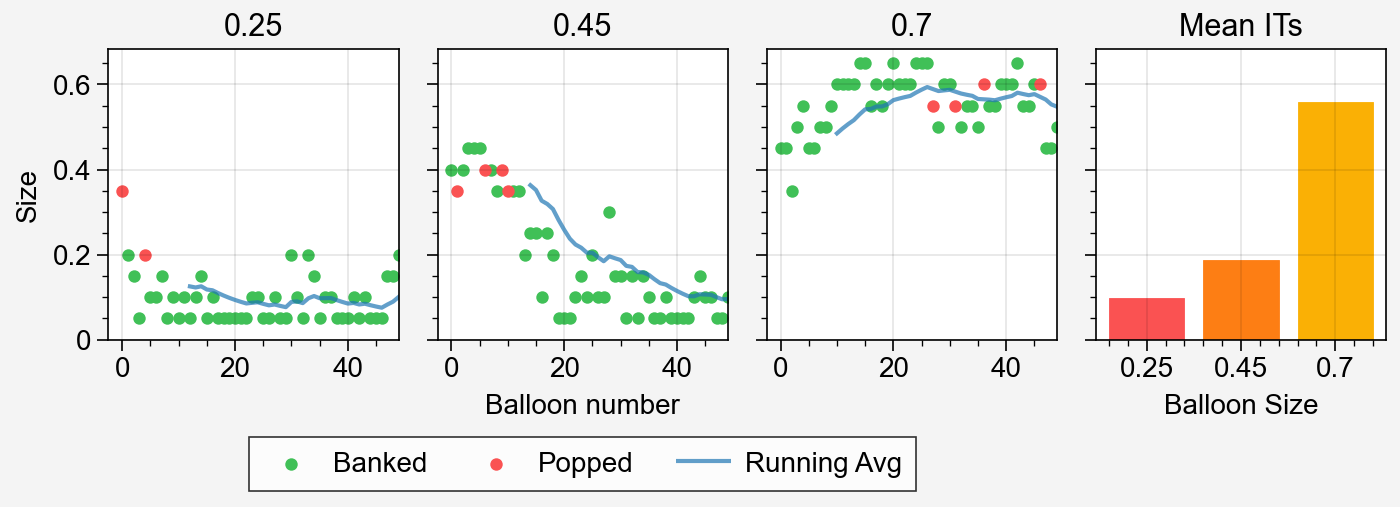

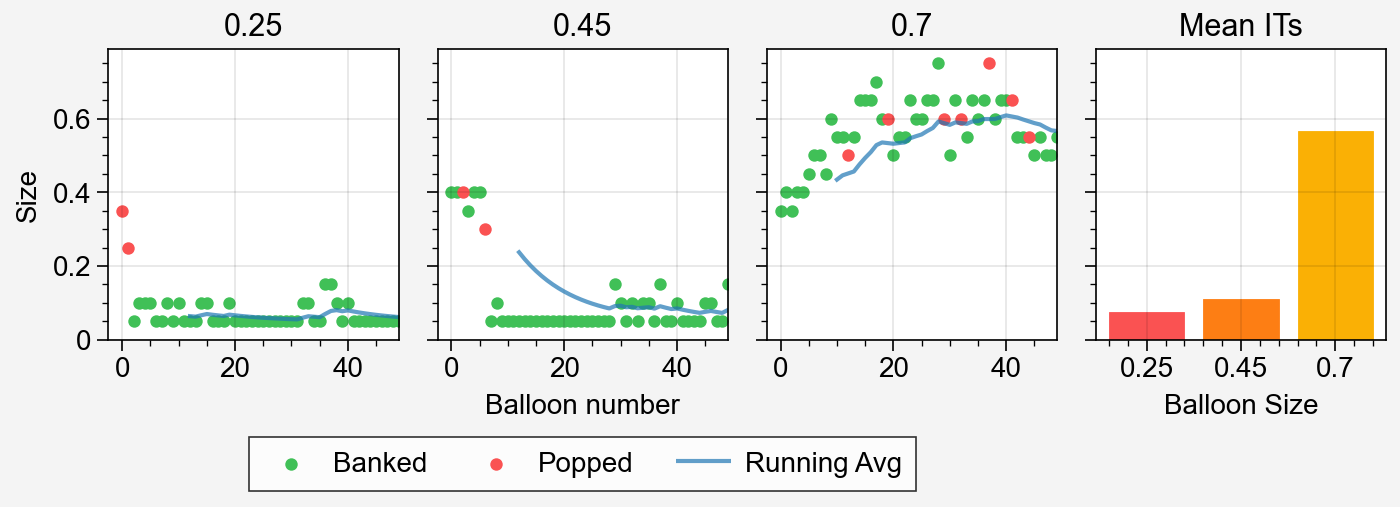

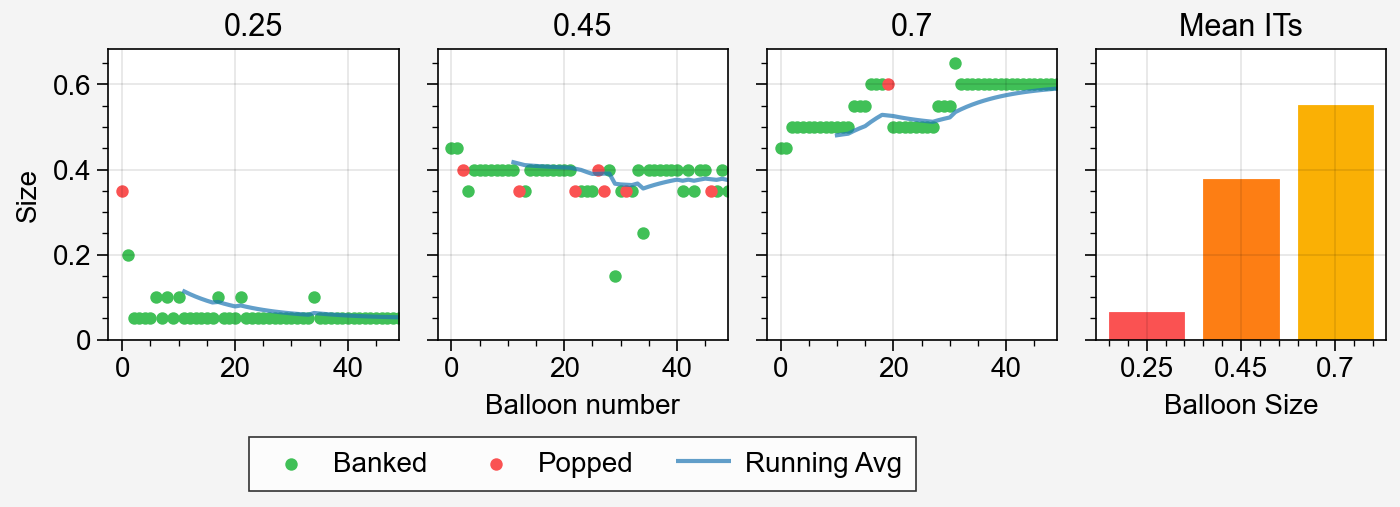

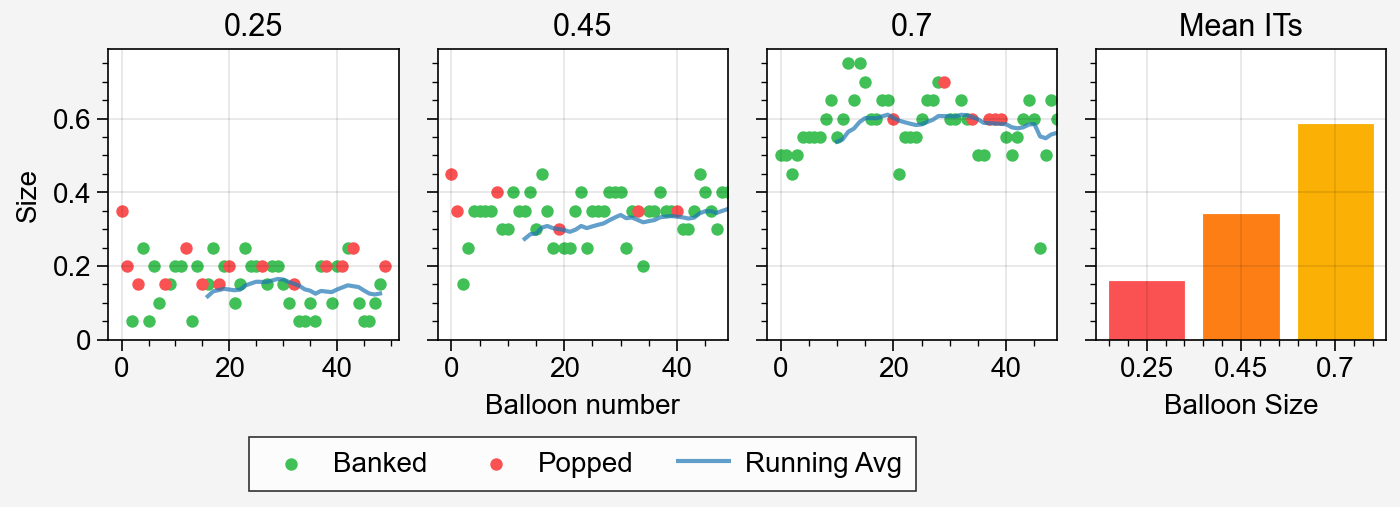

In [7]:
rand_chkidxs = select_random_model(400, with_chk=True)
chkidxs = []
for chkidx in rand_chkidxs:
    # test = summary['human_exploration'][chkidx[:4]] 
    # test = summary['human_bimodal_its'][chkidx[:4]] 
    test = summary['bimodal_its'][chkidx[:4]]
    if test:
        chkidxs.append(chkidx)

for chkidx in chkidxs[:5]:
    human_mus = [1, 5, 10]
    its = res['unpopped_sizes'][chkidx][human_mus]
    rews = res['last_sizes'][chkidx][human_mus]
    pops = [r == 0 for r in rews]
    means = [np.mean(it) for it in its]

    colors = ['0.25', '0.45', '0.7']
    fig, ax = pplt.subplots(ncols=4, figwidth=7, spanx=False)
    for i in range(3):
        lines = []
        it = its[i]
        pop = pops[i]
        pop_x = list(np.argwhere(pop).reshape(-1))
        nopop_x = list(np.argwhere(~pop).reshape(-1))
        pop_y = list(it[pop])
        nopop_y = list(it[~pop])
        avg = list(ewma(nopop_y))[10:]
        avg_x = np.array(nopop_x[10:], dtype='float')
        
        lines.append(ax[i].scatter(nopop_x, nopop_y, c='green6', s=15, label='Banked'))
        lines.append(ax[i].scatter(pop_x, pop_y, c='red6', s=15, label='Popped'))
        lines.append(ax[i].plot(avg_x, avg,
                alpha=0.7, label='Running Avg', c=rgb_colors[0]))
        ax[i].format(title=colors[i])

    ax[1].format(ylabel='Size', xlabel='Balloon number',)
    ax[1].legend(lines, loc='b')

    ax[3].sharey = False
    ax[3].bar(means, c=['red6', 'orange6', 'yellow6'])
    ax[3].format(xlocator=range(3), xformatter=colors, title='Mean ITs',
                xlabel='Balloon Size')

    idx = chkidx[:4]
    # print(chkidx)
    # print(f'Explorer: {summary["human_exploration"][idx] > 0.06}')
    # print(f'Bimodal: {summary["human_bimodal_its"][idx] == 1}')

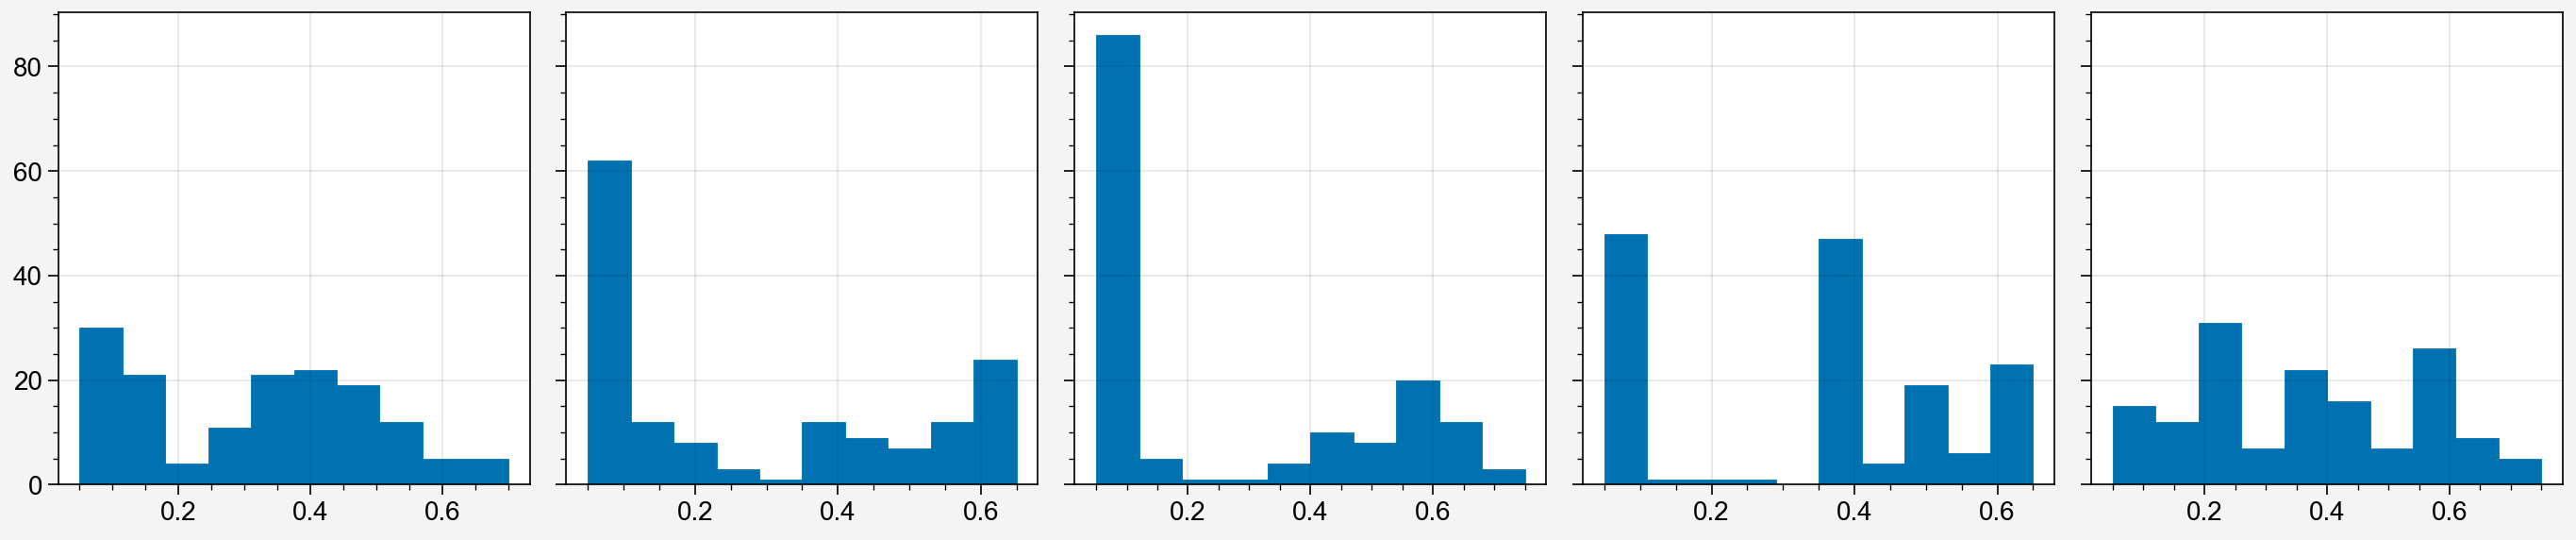

In [8]:
fig, ax = pplt.subplots(ncols=5)
for i, chkidx in enumerate(chkidxs[:5]):
    its = res['unpopped_sizes'][chkidx][human_mus]
    rews = res['last_sizes'][chkidx][human_mus]
    pops = [r == 0 for r in rews]
    ax[i].hist(np.concatenate(its))
 


In [71]:
from sklearn.mixture import GaussianMixture

def fit_gmm(data, max_components=3):
    bic = []
    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n, random_state=0)
        gmm.fit(data.reshape(-1, 1))
        bic.append(gmm.bic(data.reshape(-1, 1)))
        
    return np.argmin(bic)+1
    # return bic

In [72]:
num_components = []
for chkidx in chkidxs:
    its = res['unpopped_sizes'][chkidx][human_mus]
    rews = res['last_sizes'][chkidx][human_mus]
    pops = [r == 0 for r in rews]
    num_components.append(fit_gmm(np.concatenate(its)))
(np.array(num_components) == 2).sum()

198

In [79]:
all_bimodal_its = []
for unpopped in all_unpopped_its:
    its = np.concatenate(unpopped)
    all_bimodal_its.append(fit_gmm(its))
(np.array(all_bimodal_its) == 2).sum()
all_bimodal_its = np.array(all_bimodal_its) == 2

In [80]:
all_bimodal_its

array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False,  True, False])

In [15]:
num_components = []
chkidx = chkidxs[0]
its = res['unpopped_sizes'][chkidx][human_mus]
rews = res['last_sizes'][chkidx][human_mus]
pops = [r == 0 for r in rews]
num_components.append(fit_gmm(np.concatenate(its)))

In [25]:
len(chkidxs)

103

45

In [28]:
chkidxs = select_chks_by_dimension(with_chk=True)
num_components = []
for chkidx in chkidxs:
    its = res['unpopped_sizes'][chkidx][human_mus]
    rews = res['last_sizes'][chkidx][human_mus]
    pops = [r == 0 for r in rews]
    num_components.append(fit_gmm(np.concatenate(its)))
(np.array(num_components) == 2).sum()

198

In [30]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

2

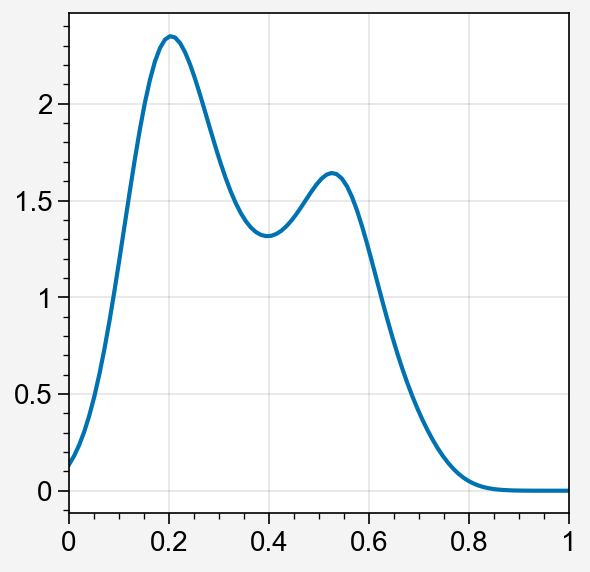

In [69]:
chkidx = chkidxs[12]
its = res['unpopped_sizes'][chkidx][human_mus]
kde = gaussian_kde(np.concatenate(its))
x = np.linspace(0, 1, 100)
density = kde(x)
its = res['unpopped_sizes'][chkidx][human_mus]
fig, ax = pplt.subplots()
ax.plot(x, density)

# ys, xs = np.histogram(np.concatenate(its))
# for x, y in zip(xs, ys):
    # ax.bar(x, y/100, c=rgb_colors[1])
len(find_peaks(density)[0])

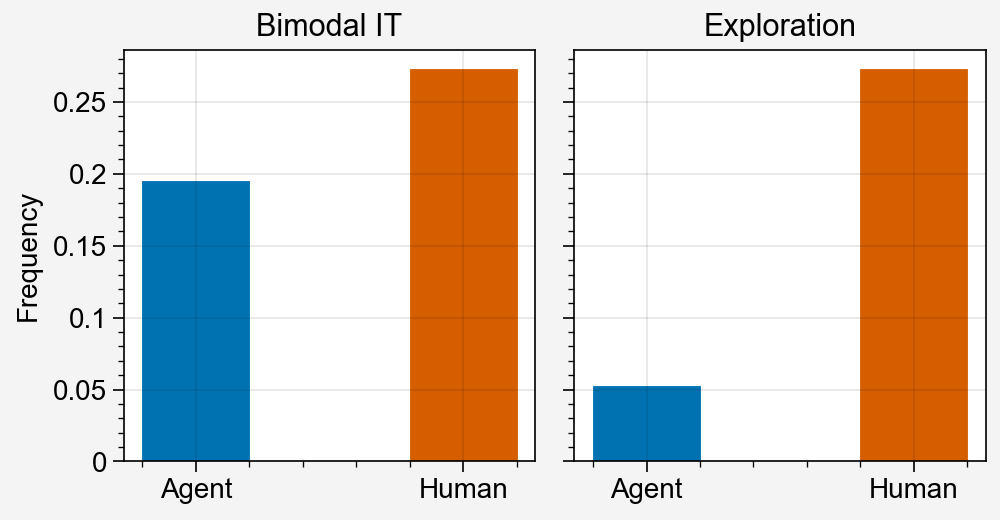

In [83]:
fig, ax = pplt.subplots(ncols=2, figwidth=5)
human_bimodal = 0.272727
human_exploration = 0.272727

ax[0].bar(0, summary['human_bimodal_its'].mean())
ax[1].bar(0, (summary['human_exploration']).mean())

ax[0].bar(1, human_bimodal)
ax[1].bar(1, human_exploration)

ax[0].format(title='Bimodal IT')
ax[1].format(title='Exploration')

ax.format(xlocator=range(2), xformatter=['Agent', 'Human'],
          ylabel='Frequency')

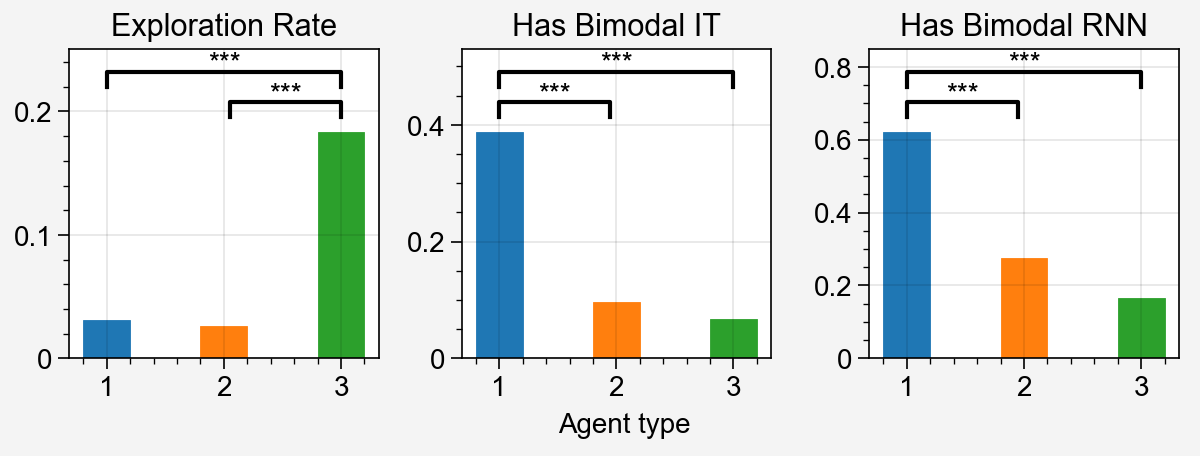

In [85]:
summary = pickle.load(open('data/meta_summary', 'rb'))
fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['human_exploration', 'human_bimodal_its', 'bimodal_rnn']
plot_keys = ['human_exploration', 'bimodal_its', 'bimodal_rnn']
plot_labels = ['Exploration Rate', 'Has Bimodal IT', 'Has Bimodal RNN']
for i in range(3):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        ax[i].bar(j, np.mean(y), c=rgb_colors[j])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=False)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

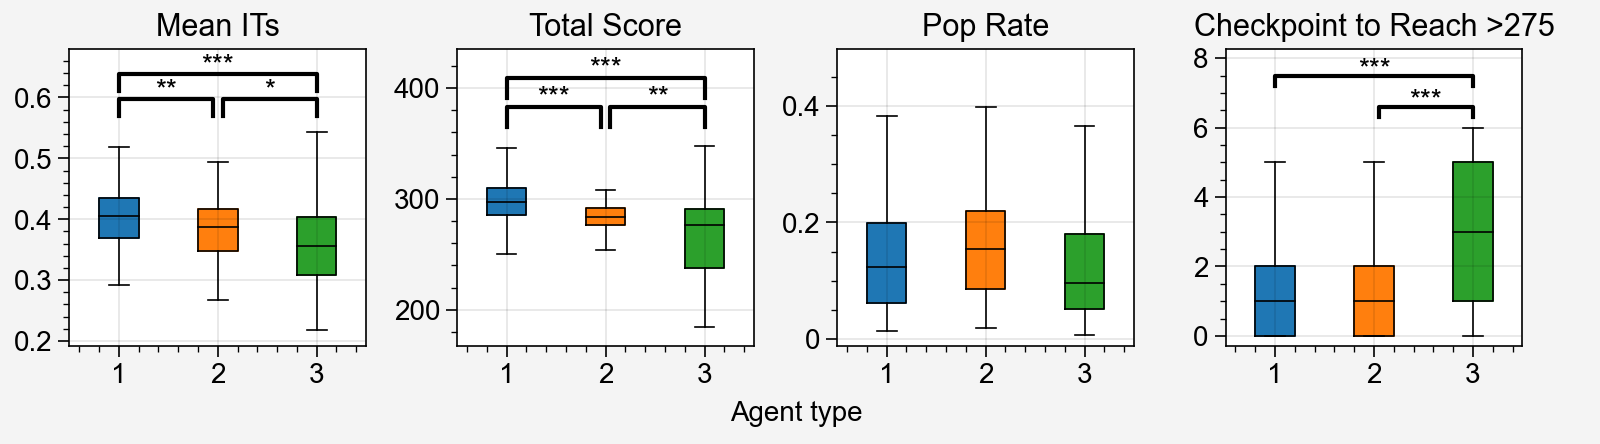

In [ ]:
fig, ax = pplt.subplots(ncols=4, sharey=False, figwidth=8)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['mean_its', 'total_score', 'pop_rate', 'first_chks']
plot_labels = ['Mean ITs', 'Total Score', 'Pop Rate', 'Checkpoint to Reach >275']
for i in range(4):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_labels[i])

    bar_dy_ratio = 3 if i == 3 else None
    lim_dy_ratio = 4.5 if i == 3 else None
    agent_type_significance_test(ys, ax[i], bar_dy_ratio=bar_dy_ratio,
                                 lim_dy_ratio=lim_dy_ratio)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])